In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from dataclasses import dataclass
from typing import Tuple, Optional

# Configuration and Helper Classes

In [2]:
@dataclass
class SimulationConfig:
    """Configuration parameters for CACC simulation."""
    
    # Simulation parameters
    num_vehicles: int = 5  # Number of vehicles in the platoon
    total_steps: int = 150  # Total number of simulation time steps
    sampling_time: float = 0.1  # Time step duration in seconds
    prediction_horizon: int = 5  # MPC prediction horizon (number of steps to look ahead)
    
    # Vehicle parameters
    time_headway: float = 0.7  # Desired time headway between vehicles in seconds
    vehicle_length: float = 5.0  # Length of each vehicle in meters
    driveline_time_constant: float = 0.1  # Vehicle driveline time constant (tau) in seconds
    min_spacing: float = 2.0  # Minimum bumper-to-bumper spacing in meters
    
    # Control limits
    min_acceleration: float = -4.0  # Minimum acceleration limit in m/s²
    max_acceleration: float = 3.0  # Maximum acceleration limit in m/s²
    min_control_input: float = -4.0  # Minimum control input in m/s²
    max_control_input: float = 3.0  # Maximum control input in m/s²
    max_velocity: float = 35.0  # Maximum velocity limit in m/s (~ 80 mph)
    
    # Leader vehicle reference velocity (m/s)
    leader_reference_velocity: float = 30.0  # Target velocity for the leader vehicle in m/s
    
    @property
    def total_spacing(self) -> float:
        """Total desired spacing between vehicles (includes vehicle length)."""
        return self.min_spacing + self.vehicle_length
    
    @property
    def leader_reference_state(self) -> np.ndarray:
        """Reference state for leader vehicle: [position, velocity, acceleration]."""
        return np.array([0, self.leader_reference_velocity, 0])
    
    @property
    def leader_cost_matrix(self) -> np.ndarray:
        """Cost matrix Q for leader vehicle MPC optimization."""
        return np.array([
            [0, 0, 0],   # No cost on position
            [0, 5, 0],   # Cost on velocity tracking
            [0, 0, 1]    # Cost on acceleration
        ])
    
    @property
    def follower_reference_state(self) -> np.ndarray:
        """Reference state for follower vehicles: [spacing_error, relative_velocity, acceleration]."""
        return np.array([self.total_spacing, 0, 0])
    
    @property
    def follower_cost_matrix(self) -> np.ndarray:
        """Cost matrix Q for follower vehicle MPC optimization."""
        return np.array([
            [5, 0, 0],      # Spacing error cost
            [0, 3, 0],      # Relative velocity cost
            [0, 0, 1]       # Cost on acceleration smoothness
        ])
    
    @property
    def state_space_matrices(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Compute state-space matrices for follower vehicles."""
        dt = self.sampling_time
        T = self.time_headway
        tau = self.driveline_time_constant
        
        A = np.array([
            [1, dt, -T * dt],
            [0, 1, -dt],
            [0, 0, 1 - dt / tau]
        ])
        B = np.array([0, 0, dt / tau])
        D = np.array([0, dt, 0])
        
        return A, B, D
    
    @property
    def leader_state_space_matrices(self) -> Tuple[np.ndarray, np.ndarray]:
        """Compute state-space matrices for leader vehicle."""
        dt = self.sampling_time
        tau = self.driveline_time_constant
        
        A = np.array([
            [0, 0, 0],
            [0, 1, dt],
            [0, 0, 1 - dt / tau]
        ])
        B = np.array([0, 0, dt / tau])
        
        return A, B


# MPC Function (Used for All Vehicles)

In [3]:
def solve_mpc(
    state_matrix: np.ndarray,
    control_matrix: np.ndarray,
    initial_state: np.ndarray,
    initial_velocity: float,
    reference_state: np.ndarray,
    cost_matrix: np.ndarray,
    config: SimulationConfig,
    solver: Optional[str] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Solve MPC optimization problem for any vehicle in the platoon.
    
    This function can be used for both leader and follower vehicles by providing
    the appropriate state matrices, reference states, and cost matrices.
    
    Args:
        state_matrix: State transition matrix A
        control_matrix: Control input matrix B
        initial_state: Current state vector
        initial_velocity: Current velocity
        reference_state: Reference state to track
        cost_matrix: Cost matrix Q for optimization
        config: Simulation configuration containing all parameters
        solver: CVXPY solver to use (None for auto-selection)
        
    Returns:
        state_trajectory: Predicted state trajectory (3 x N+1)
        velocity_trajectory: Predicted velocity trajectory (N+1,)
    """
    N = config.prediction_horizon
    
    # Decision variables
    state = cp.Variable((3, N + 1))
    control = cp.Variable(N)
    velocity = cp.Variable(N + 1)
    
    # Constraints
    constraints = [
        state[:, 0] == initial_state,
        velocity[0] == initial_velocity
    ]
    
    # Acceleration limits
    constraints.append(state[2, :] >= config.min_acceleration)
    constraints.append(state[2, :] <= config.max_acceleration)
    
    # Control input limits
    constraints.append(control >= config.min_control_input)
    constraints.append(control <= config.max_control_input)
    
    # Velocity limits
    constraints.append(velocity >= 0)
    constraints.append(velocity <= config.max_velocity)
    
    # Cost function: terminal cost + stage costs
    cost = cp.quad_form(state[:, N] - reference_state, cost_matrix)
    
    # Dynamics and stage costs
    for k in range(N):
        constraints.append(state[:, k + 1] == state_matrix @ state[:, k] + control_matrix * control[k])
        constraints.append(velocity[k + 1] == velocity[k] + state[2, k] * config.sampling_time)
        cost += cp.quad_form(state[:, k] - reference_state, cost_matrix)
    
    # Solve optimization problem
    objective = cp.Minimize(cost)
    problem = cp.Problem(objective, constraints)
    
    # Try to solve with specified or default solver
    if solver is not None:
        try:
            problem.solve(verbose=False, solver=solver)
        except (cp.SolverError, Exception) as e:
            # If specified solver fails, try default
            print(f"Warning: Solver {solver} failed ({str(e)}), using default solver")
            problem.solve(verbose=False)
    else:
        # Use default solver (CVXPY will choose an appropriate one)
        problem.solve(verbose=False)
    
    if state.value is None:
        raise ValueError("MPC optimization failed to find a solution")
    
    return state.value, velocity.value


# Main Simulation

In [4]:
# Initialize simulation configuration
config = SimulationConfig()

# Get state-space matrices
A_follower, B_follower, _ = config.state_space_matrices
A_leader, B_leader = config.leader_state_space_matrices

# Initialize state arrays
positions = np.zeros((config.num_vehicles, config.total_steps + 1))
velocities = np.zeros((config.num_vehicles, config.total_steps + 1))
accelerations = np.zeros((config.num_vehicles, config.total_steps + 1))
spacing_errors = np.zeros((config.num_vehicles, config.total_steps + 1))

# Set initial conditions
positions[:, 0] = 20 * np.arange(config.num_vehicles, 0, -1)
velocities[:, 0] = 15.0 * np.ones(config.num_vehicles)
accelerations[:, 0] = np.zeros(config.num_vehicles)

# Compute initial spacing errors for followers
for vehicle_idx in range(1, config.num_vehicles):
    spacing_errors[vehicle_idx, 0] = (positions[vehicle_idx - 1, 0] - 
                                      positions[vehicle_idx, 0] - 
                                      config.time_headway * velocities[vehicle_idx, 0])

print(f"Starting simulation with {config.num_vehicles} vehicles for {config.total_steps} steps...")
print(f"Leader reference velocity: {config.leader_reference_velocity} m/s")
print(f"Time headway: {config.time_headway} s")
print(f"Desired spacing: {config.total_spacing} m")

Starting simulation with 5 vehicles for 150 steps...
Leader reference velocity: 30.0 m/s
Time headway: 0.7 s
Desired spacing: 7.0 m


In [5]:
# Run simulation
for time_step in range(config.total_steps):
    
    # Solve MPC for each vehicle
    for vehicle_idx in range(config.num_vehicles):
        
        if vehicle_idx == 0:  # Leader vehicle
            leader_state = np.array([
                positions[0, time_step],
                velocities[0, time_step],
                accelerations[0, time_step]
            ])
            
            state_traj, velocity_traj = solve_mpc(
                state_matrix=A_leader,
                control_matrix=B_leader,
                initial_state=leader_state,
                initial_velocity=velocities[vehicle_idx, time_step],
                reference_state=config.leader_reference_state,
                cost_matrix=config.leader_cost_matrix,
                config=config
            )
            
            # Extract results
            velocities[vehicle_idx, time_step + 1] = velocity_traj[1]
            accelerations[vehicle_idx, time_step + 1] = state_traj[2, 1]
            
        else:  # Follower vehicle
            # Construct follower state: [spacing_error, relative_velocity, acceleration]
            follower_state = np.array([
                spacing_errors[vehicle_idx, time_step],
                velocities[vehicle_idx - 1, time_step] - velocities[vehicle_idx, time_step],
                accelerations[vehicle_idx, time_step]
            ])
            
            state_traj, velocity_traj = solve_mpc(
                state_matrix=A_follower,
                control_matrix=B_follower,
                initial_state=follower_state,
                initial_velocity=velocities[vehicle_idx, time_step],
                reference_state=config.follower_reference_state,
                cost_matrix=config.follower_cost_matrix,
                config=config
            )
            
            # Extract results
            velocities[vehicle_idx, time_step + 1] = velocity_traj[1]
            accelerations[vehicle_idx, time_step + 1] = state_traj[2, 1]
        
        # Enforce non-negative velocity
        if velocities[vehicle_idx, time_step + 1] < 0:
            velocities[vehicle_idx, time_step + 1] = 0
        
        # Update position
        positions[vehicle_idx, time_step + 1] = (positions[vehicle_idx, time_step] + 
                                                  config.sampling_time * velocities[vehicle_idx, time_step])
        
        # Update spacing error for next iteration
        if vehicle_idx > 0:
            spacing_errors[vehicle_idx, time_step + 1] = (
                positions[vehicle_idx - 1, time_step + 1] - 
                positions[vehicle_idx, time_step + 1] - 
                config.time_headway * velocities[vehicle_idx, time_step + 1]
            )
    
    # Progress indicator
    if (time_step + 1) % 50 == 0:
        print(f"Completed step {time_step + 1}/{config.total_steps}")

print("Simulation completed successfully!")


Completed step 50/150
Completed step 100/150
Completed step 100/150
Completed step 150/150
Simulation completed successfully!
Completed step 150/150
Simulation completed successfully!


# Visualization

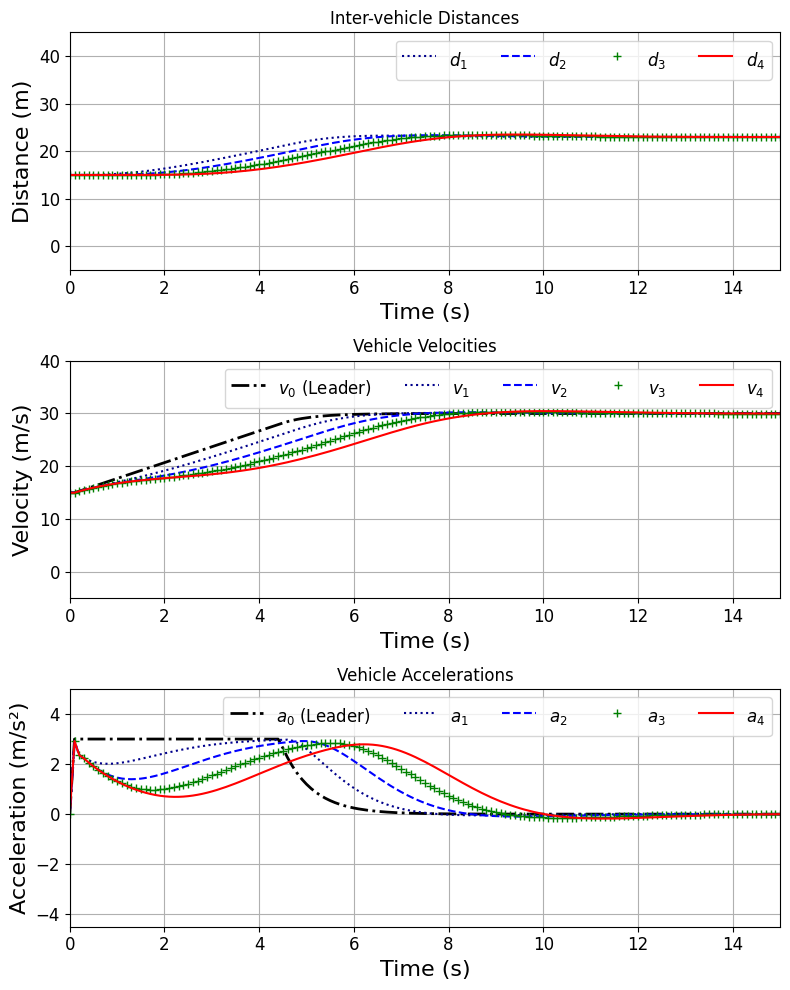

In [6]:
def plot_simulation_results(
    time_steps: np.ndarray,
    positions: np.ndarray,
    velocities: np.ndarray,
    accelerations: np.ndarray,
    config: SimulationConfig,
    figsize: Tuple[int, int] = (8, 10)
) -> None:
    """
    Plot simulation results: inter-vehicle distances, velocities, and accelerations.
    
    Args:
        time_steps: Array of time values
        positions: Position trajectories for all vehicles
        velocities: Velocity trajectories for all vehicles
        accelerations: Acceleration trajectories for all vehicles
        config: Simulation configuration
        figsize: Figure size (width, height)
    """
    # Configure plot styling
    plt.rc('font', size=10)
    plt.rc('axes', titlesize=12)
    plt.rc('axes', labelsize=16)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.rc('legend', fontsize=12)
    plt.rc('figure', titlesize=10)
    
    # Line styles and colors
    line_styles = [':', '--', '+', '-', '*', '3-', 'x', '|-', '-.']
    colors = ['darkblue', 'b', 'g', 'r', 'tab:orange', 'deepskyblue',
              'tab:orange', 'tab:purple', 'darkred', 'mediumaquamarine']
    
    # Create subplots
    fig, axes = plt.subplots(3, gridspec_kw={'height_ratios': [1, 1, 1]})
    fig.set_size_inches(*figsize)
    
    # --- Plot 1: Inter-vehicle distances ---
    for vehicle_idx in range(config.num_vehicles - 1):
        inter_vehicle_distance = (positions[vehicle_idx, :] - 
                                 positions[vehicle_idx + 1, :] - 
                                 config.vehicle_length)
        style_idx = vehicle_idx % len(line_styles)
        color_idx = vehicle_idx % len(colors)
        
        axes[0].plot(time_steps, inter_vehicle_distance, 
                    line_styles[style_idx], 
                    c=colors[color_idx], 
                    label=f'$d_{{{vehicle_idx + 1}}}$')
    
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Distance (m)')
    axes[0].set_xlim(time_steps[0], time_steps[-1])
    axes[0].set_ylim(-5, 45)
    axes[0].grid(True)
    axes[0].legend(ncol=min(9, config.num_vehicles - 1), handleheight=2, loc='upper right')
    axes[0].set_title('Inter-vehicle Distances')
    
    # --- Plot 2: Velocities ---
    # Leader vehicle (special style)
    axes[1].plot(time_steps, velocities[0, :], 'k-.', linewidth=2, label='$v_0$ (Leader)')
    
    # Follower vehicles
    for vehicle_idx in range(1, config.num_vehicles):
        style_idx = (vehicle_idx - 1) % len(line_styles)
        color_idx = (vehicle_idx - 1) % len(colors)
        
        axes[1].plot(time_steps, velocities[vehicle_idx, :], 
                    line_styles[style_idx], 
                    c=colors[color_idx], 
                    label=f'$v_{{{vehicle_idx}}}$')
    
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Velocity (m/s)')
    axes[1].set_xlim(time_steps[0], time_steps[-1])
    axes[1].set_ylim(-5, 40)
    axes[1].grid(True)
    axes[1].legend(ncol=min(10, config.num_vehicles), handleheight=2, loc='upper right')
    axes[1].set_title('Vehicle Velocities')
    
    # --- Plot 3: Accelerations ---
    # Leader vehicle (special style)
    axes[2].plot(time_steps, accelerations[0, :], 'k-.', linewidth=2, label='$a_0$ (Leader)')
    
    # Follower vehicles
    for vehicle_idx in range(1, config.num_vehicles):
        style_idx = (vehicle_idx - 1) % len(line_styles)
        color_idx = (vehicle_idx - 1) % len(colors)
        
        axes[2].plot(time_steps, accelerations[vehicle_idx, :], 
                    line_styles[style_idx], 
                    c=colors[color_idx], 
                    label=f'$a_{{{vehicle_idx}}}$')
    
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Acceleration (m/s²)')
    axes[2].set_xlim(time_steps[0], time_steps[-1])
    axes[2].set_ylim(-4.5, 5)
    axes[2].grid(True)
    axes[2].legend(ncol=config.num_vehicles, handleheight=2, loc='upper right')
    axes[2].set_title('Vehicle Accelerations')
    
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout()
    plt.show()


# Generate time array
time_array = np.arange(config.total_steps + 1) * config.sampling_time

# Plot results
plot_simulation_results(
    time_steps=time_array,
    positions=positions,
    velocities=velocities,
    accelerations=accelerations,
    config=config
)